# Get started with `gappyfpca`

### Load modules
- From gappyfpca load gappyfpca to generate the fpca decompostion and reconstruct_func to reconstruct the functions from the decomposition
- Numpy is required to generate synthetic data in a np.array format, and matplotlib to plot the results

In [2]:
from gappyfpca.fpca import gappyfpca, reconstruct_func
import numpy as np
import matplotlib.pyplot as plt

### Generate some synthetic data

- For gappyfpca the data must be saved in a np.ndarray of size M x L where M (rows) is the number of data functions and L (cols) is the length of each function. 
- Each function must be discretised to the same length intervals, and missing data is indicated with NaN
- To ensure the pseudocovariance can be calculated each function must be more than 50% complete. This is a hard limit and depending on the strucutre of the data a lower percentage of complete data may work
    - TBC : call `data_check()` to check that the psuedocovariance can be calculated with the current structure of the data, if Fail, suggestion to cleaning of data will be given

In [3]:
# generate synthetic dataset to test

# Parameters
M = 1000  # Number of functions
L = 50   # Length of each function

# Sinusoidal patterns with random frequencies and phases
x = np.linspace(0, 2 * np.pi, L)
functions = np.array([10+np.random.uniform(0.1, 5)*np.sin(x * np.random.uniform(1, 1.5) + np.random.uniform(0,  np.pi/2)) 
                      for _ in range(M)])

# Random polynomials
#functions = np.array([np.polyval(np.random.uniform(-1, 1, size=3), np.linspace(-1, 1, L)) 
#                      for _ in range(M)])

data=np.copy(functions)
#artifically gappy it
for i in range(M):
    # Determine the number of NaNs to insert (0 to <50% of the function length)
    num_nans = np.random.randint(0, L // 2)  
    # Randomly select indices to replace with NaN
    nan_indices = np.random.choice(L, num_nans, replace=False)
    # Replace selected indices with NaN
    data[i, nan_indices] = np.nan



### Find fPCA representation

- call `gappyfpca()` to compute the fPCA representation
- Required inputs are
    - data matrix
    - explained variance of components to return
- Optional inputs are 
    - the absolute max number of iterations, the number of iterations of convergence and a parallel flag
    - If iparallel = True, Multiprocessing is called for the calculation of psuedocovariance and weight optimisation to speed up computation
- The outputs are:
    - fpca_comps, N+1 x L, where the first row is the data mean and N is the number of components
    - fpca_coefs, M x N
    - eigenvalues for full deocompostion, size = min(L,M)
    - run_stat: for an indication of convergence, an array where first row is the first coefficient and second row is the change in mean reconstructed function for each iteration, 

In [4]:
# Generate fpca of full data using

fpca_comps,fpca_coefs,evalue,run_stat=gappyfpca(data,0.95,max_iter=15,num_iter=5,iparallel=0)

Step 1, time: 0.8129880428314209
Iteration  1
Time:  0.5504388809204102
Iteration  2
Time:  0.5343828201293945
Iteration  3
Time:  0.529984712600708
Iteration  4
Time:  0.5314528942108154
Iteration  5
Time:  0.551048994064331
Iteration  6
Time:  0.5397088527679443


### Reconstruct data

- call `reconstruct_func()`
- Inputs are fpca_mean (L), fpca_comps (N x L) , fpca_coefs (M x N)
- Returns an array of the reconstructed functions, size M x L

In [5]:
# Impute missing data

function_recon=reconstruct_func(fpca_comps[0,:],fpca_comps[1:,:],fpca_coefs)


### Plot raw data vs reconstruction

0.2937113683058522 0.3097144977085161


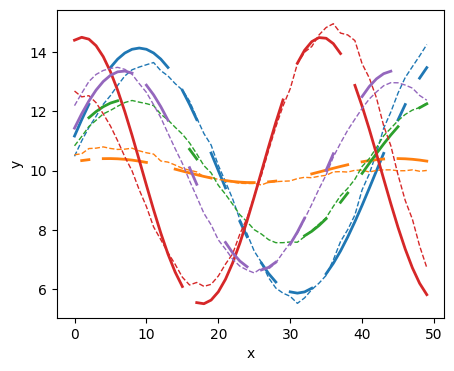

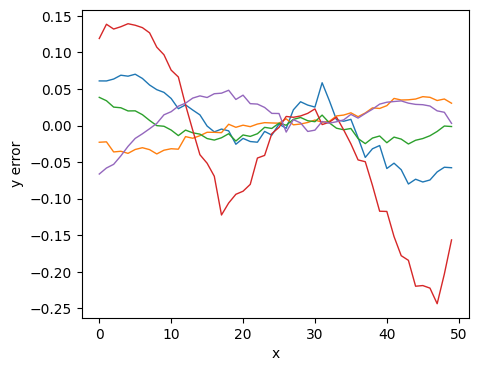

In [6]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
colors = plt.cm.tab10.colors
for i in range(5):
    ax.plot(data[i,:],linestyle='-',linewidth=2,color=colors[i])
    ax.plot(function_recon[i,:],linestyle='--',linewidth=1,color=colors[i])
ax.set_xlabel('x')
ax.set_ylabel('y')

fig,ax=plt.subplots(1,1,figsize=(5,4))

for i in range(5):
    ax.plot((functions[i,:]-function_recon[i,:])/functions[i,:],linestyle='-',linewidth=1,color=colors[i])
ax.set_xlabel('x')
ax.set_ylabel('y error')

missing_data=functions[np.isnan(data)]
print(np.mean(np.abs((functions-function_recon))),np.mean(np.abs(functions[np.isnan(data)]-function_recon[np.isnan(data)])))